In [ ]:
# ==============================================================================
# SCRIPT ANALISIS SPASIAL DAN KLASIFIKASI SPI-1 (DROUGHT INDEX)
# STUDI KASUS: PROVINSI JAMBI
# Penulis: Jariyan Arifudin
# Data: CHIRPS v3 (Downscaled & Bias Corrected)
# ==============================================================================

In [ ]:
## 1. IMPOR PUSTAKA & INSTALASI
import os

# Cek apakah rioxarray sudah ada, jika belum install
try:
    import rioxarray
except ImportError:
    print("Pustaka rioxarray tidak ditemukan. Menginstal...")
    !pip install rioxarray geopandas rasterio numpy scipy leafmap xarray matplotlib
    print("Instalasi selesai. Silakan Restart Runtime jika masih error.")
    import rioxarray

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio
from rasterio import features
from rasterio.mask import geometry_mask
from shapely.geometry import shape
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from google.colab import drive

# Instalasi paket tambahan (jika belum ada)
try:
    import leafmap
except ImportError:
    print("Menginstal pustaka geospasial...")
    !pip install rioxarray geopandas rasterio numpy scipy leafmap xarray matplotlib >> /dev/null

Pustaka rioxarray tidak ditemukan. Menginstal...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.8/662.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:00:00
  Attempting

In [ ]:
## 2. KONFIGURASI
# ------------------------------------------------------------------------------
# Mount Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Path Direktori (Sesuaikan jika ada perubahan)
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Skripsi'
ADMIN_PATH = os.path.join(BASE_DIR, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CHIRPS_DIR = os.path.join(BASE_DIR, 'CHIRPS v3/bias_corrected_regression/downscaled_1km_metric/')
OUTPUT_DIR = os.path.join(BASE_DIR, 'SPI-Output/')

Mounted at /content/drive


In [ ]:
def load_boundary(path):
    """Memuat batas administrasi dan memastikannya dalam EPSG:4326."""
    gdf = gpd.read_file(path)
    return gdf.to_crs(epsg=4326)

def load_chirps(boundary, start_year, end_year):
    """Load, Reproject, dan Clip data CHIRPS dengan background NaN (Transparan)."""
    datasets = []
    boundary = boundary.to_crs(epsg=4326)

    print(f">> Memulai proses loading data tahun {start_year} s.d {end_year}...")

    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            file_path = os.path.join(CHIRPS_DIR, f"chirps-v3.0.{year}.{month:02d}.1000m_metric.tif")

            if os.path.exists(file_path):
                try:
                    ds = rioxarray.open_rasterio(file_path)

                    if ds.rio.crs is None:
                        ds.rio.write_crs("EPSG:32748", inplace=True)

                    ds_wgs84 = ds.rio.reproject("EPSG:4326")

                    # Clip dengan boundary
                    clipped = ds_wgs84.rio.clip(boundary.geometry.values, boundary.crs, all_touched=True)

                    # Tambah dimensi waktu
                    clipped = clipped.expand_dims(time=[pd.to_datetime(f"{year}-{month:02d}-01")])

                    datasets.append(clipped)
                except Exception as e:
                    print(f"   [ERROR] Gagal memuat {file_path}: {e}")
            else:
                pass

    if datasets:
        combined = xr.concat(datasets, dim='time').squeeze('band', drop=True)
        if 'x' in combined.coords and 'y' in combined.coords:
            combined = combined.rename({'x': 'lon', 'y': 'lat'})
        print(">> Data berhasil digabungkan.")
        return combined
    else:
        raise ValueError("Tidak ada data CHIRPS yang ditemukan!")

def compute_spi(dataset):
    """Menghitung SPI-1."""
    print(">> Menghitung SPI-1...")
    precip = dataset.values
    spi_array = np.full_like(precip, np.nan)

    rows, cols = precip.shape[1], precip.shape[2]

    for i in range(rows):
        for j in range(cols):
            ts = precip[:, i, j]
            if np.isnan(ts).all():
                continue

            ts_clean = ts[~np.isnan(ts)]
            ts_clean[ts_clean == 0] = 0.01

            if len(ts_clean) >= 12:
                try:
                    alpha, _, beta = gamma.fit(ts_clean, floc=0, method='MM')
                    cdf = gamma.cdf(ts_clean, alpha, scale=beta)
                    cdf = np.clip(cdf, 1e-8, 1-1e-8)
                    spi = norm.ppf(cdf)
                    spi_array[:, i, j] = spi
                except:
                    continue

    return xr.DataArray(spi_array, dims=('time', 'lat', 'lon'), coords=dataset.coords, name='spi')

def classify_spi(spi):
    """
    Klasifikasi SPI (Revisi 5 Kelas).
    Background (NaN) tetap jadi 0.
    """
    def _classify(value):
        if np.isnan(value): return 0      # No Data / Background

        # 1. Tidak ada kekeringan (>= 1.00) -> Menggabungkan Agak Basah s.d Sangat Basah
        if value >= 1.00:   return 1

        # 2. Mendekati Normal (-0.99 s.d 0.99)
        elif value > -1.00: return 2

        # 3. Agak Kering (-1.00 s.d -1.49)
        elif value > -1.50: return 3

        # 4. Kering (-1.50 s.d -1.99) -> Severely Dry
        elif value > -2.00: return 4

        # 5. Sangat Kering (<= -2.00) -> Extremely Dry
        else:               return 5

    return xr.apply_ufunc(np.vectorize(_classify), spi, output_dtypes=[int])

def save_raster(data, path, dtype):
    """Menyimpan Raster dengan background TRANSPARAN."""
    os.makedirs(os.path.dirname(path), exist_ok=True)

    if dtype == 'int16':
        nodata_val = 0
    else:
        nodata_val = np.nan

    data.rio.write_nodata(nodata_val, inplace=True)

    if data.rio.crs is None:
        data.rio.write_crs("EPSG:4326", inplace=True)

    data.rio.to_raster(path, dtype=dtype, compress='LZW')

def raster_to_shapefile(raster_path, shapefile_path, boundary):
    """Konversi Raster ke SHP (Hanya area Jambi, background diabaikan)."""
    try:
        with rasterio.open(raster_path) as src:
            img = src.read(1)
            nodata = src.nodata

            mask = geometry_mask(boundary.geometry, transform=src.transform, invert=True, out_shape=img.shape)
            shapes_gen = features.shapes(img, transform=src.transform, mask=mask)

            geoms = []
            for g, v in shapes_gen:
                if v != nodata and v != 0:
                    geoms.append({'properties': {'class': int(v)}, 'geometry': shape(g)})

        if not geoms:
            return

        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)
        if not gdf.empty:
            gdf.to_file(shapefile_path)

    except Exception as e:
        print(f"   [ERROR SHP] {e}")

def plot_classified(data, time_idx, boundary, title):
    """Visualisasi 5 Kelas Kekeringan."""

    # WARNA (Hex Codes)
    colors = [
        '#0000FF',  # 1: Tidak ada kekeringan (Biru)
        '#90EE90',  # 2: Mendekati Normal (Hijau Muda/Light Green)
        '#FFFF00',  # 3: Agak Kering (Kuning)
        '#FFA500',  # 4: Kering (Oranye)
        '#FF0000',  # 5: Sangat Kering (Merah)
    ]

    labels = [
        'Tidak ada kekeringan', # 1
        'Mendekati Normal',     # 2
        'Agak Kering',          # 3
        'Kering',               # 4
        'Sangat Kering'         # 5
    ]

    cmap = plt.cm.colors.ListedColormap(colors)

    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    try:
        data_slice = data.isel(time=time_idx)

        # MASKING: Background (0) jadi transparan
        data_masked = data_slice.where(data_slice > 0)

        data_masked.plot(
            cmap=cmap,
            vmin=0.5, vmax=5.5, # Range diatur agar warna tepat jatuh di angka 1,2,3,4,5
            add_labels=True, add_colorbar=False, ax=ax
        )

        boundary.boundary.plot(ax=ax, color='black', linewidth=1)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

    except Exception as e:
        print(f"   [PLOT WARNING] Gagal plot: {e}")

    plt.title(title, fontsize=12, fontweight='bold')

    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
    plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
def run_processing_period(start_year, end_year):
    period_name = f"{start_year}-{end_year}"
    print(f"\n{'='*40}")
    print(f"MEMPROSES: {period_name}")
    print(f"{'='*40}")

    boundary = load_boundary(ADMIN_PATH)
    chirps = load_chirps(boundary, start_year, end_year)
    spi = compute_spi(chirps)
    classified = classify_spi(spi)

    # Folder Output
    spi_dir = os.path.join(OUTPUT_DIR, f'SPI-1_{period_name}')
    class_dir = os.path.join(OUTPUT_DIR, f'Klasifikasi_SPI-1_{period_name}')
    poly_dir = os.path.join(OUTPUT_DIR, f'Polygon_SPI-1_{period_name}')
    for d in [spi_dir, class_dir, poly_dir]:
        os.makedirs(d, exist_ok=True)

    print(">> Menyimpan output...")
    for idx in range(len(spi.time)):
        time_val = pd.to_datetime(spi.time[idx].values)
        time_str = time_val.strftime('%Y%m')

        spi_path = os.path.join(spi_dir, f'SPI-1_{time_str}.tif')
        class_path = os.path.join(class_dir, f'SPI-Class_{time_str}.tif')
        poly_path = os.path.join(poly_dir, f'SPI-Poly_{time_str}.shp')

        save_raster(spi.isel(time=idx), spi_path, dtype='float32')
        save_raster(classified.isel(time=idx), class_path, dtype='int16')

        raster_to_shapefile(class_path, poly_path, boundary)

        # Plot contoh (Agustus)
        if time_val.month == 8:
             plot_classified(classified, idx, boundary, f'SPI-1 Jambi: {time_str}')

    print(f"[SELESAI] Periode {period_name} tersimpan.")

Memulai pemrosesan data termasuk tahun 2009...

MEMPROSES: 2009-2011
>> Memulai proses loading data tahun 2009 s.d 2011...
>> Data berhasil digabungkan.
>> Menghitung SPI-1...
>> Menyimpan output...


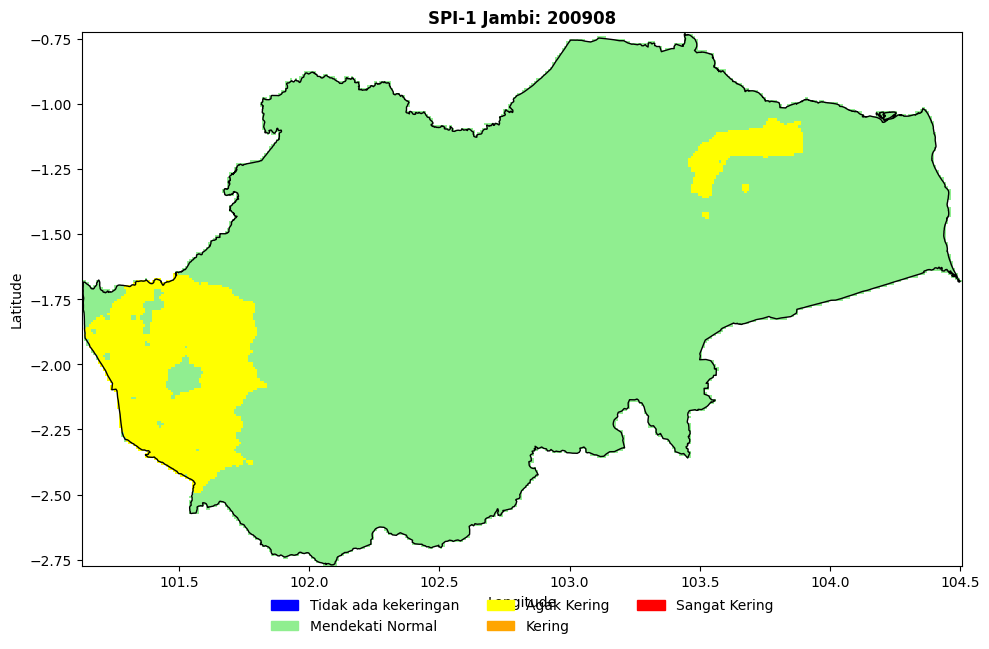

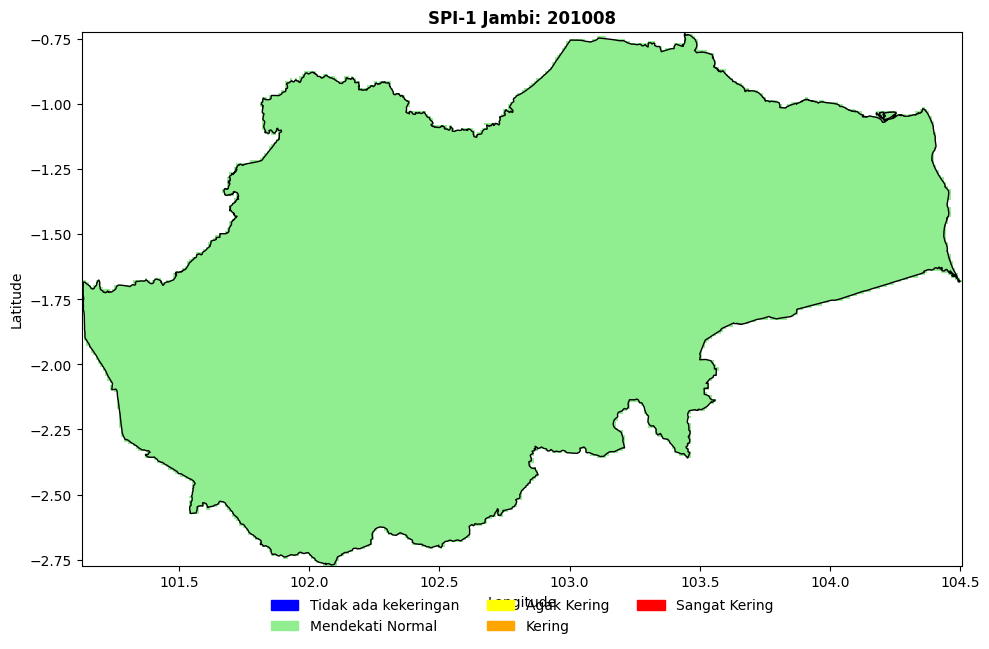

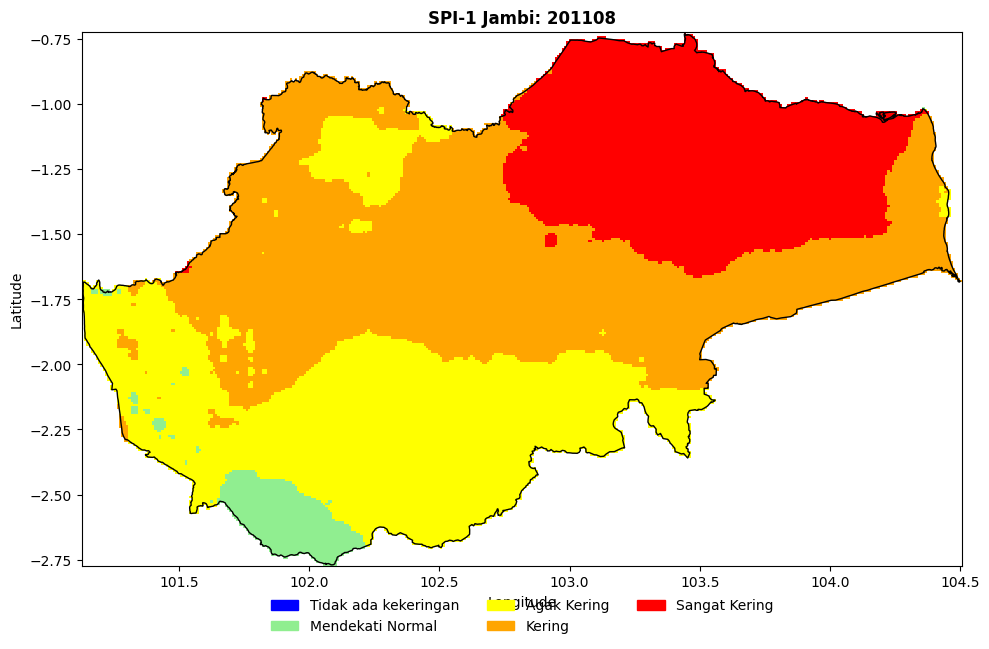

[SELESAI] Periode 2009-2011 tersimpan.

MEMPROSES: 2012-2013
>> Memulai proses loading data tahun 2012 s.d 2013...
>> Data berhasil digabungkan.
>> Menghitung SPI-1...
>> Menyimpan output...


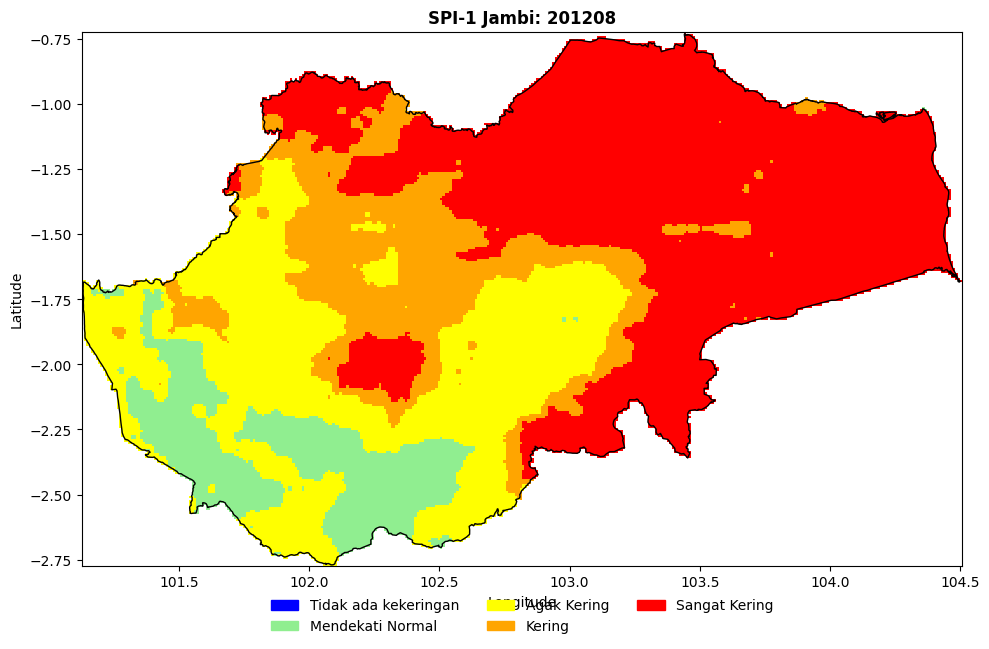

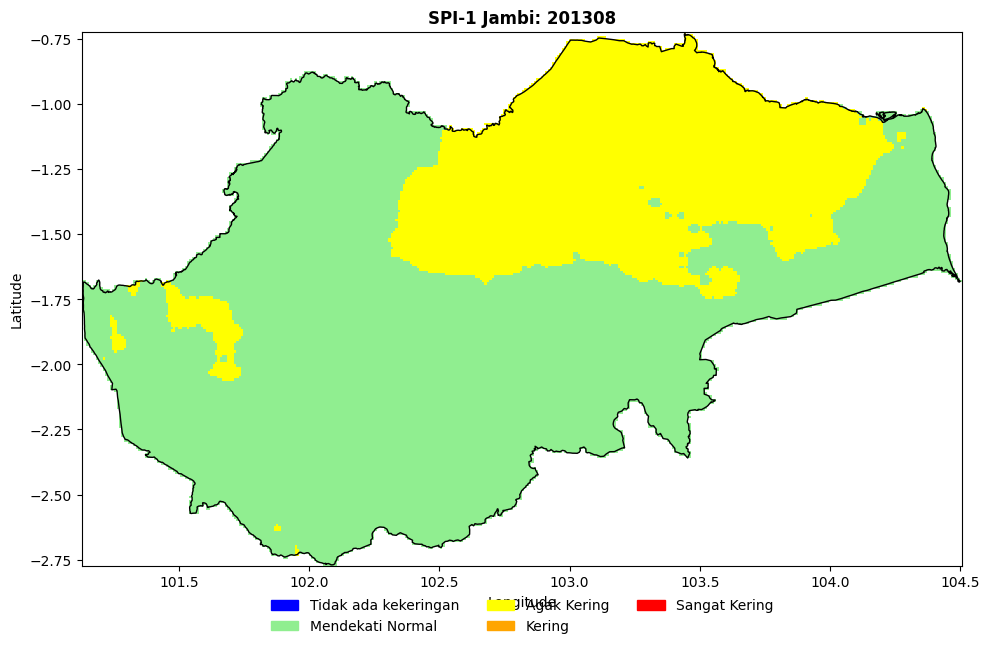

[SELESAI] Periode 2012-2013 tersimpan.

MEMPROSES: 2014-2015
>> Memulai proses loading data tahun 2014 s.d 2015...
>> Data berhasil digabungkan.
>> Menghitung SPI-1...
>> Menyimpan output...


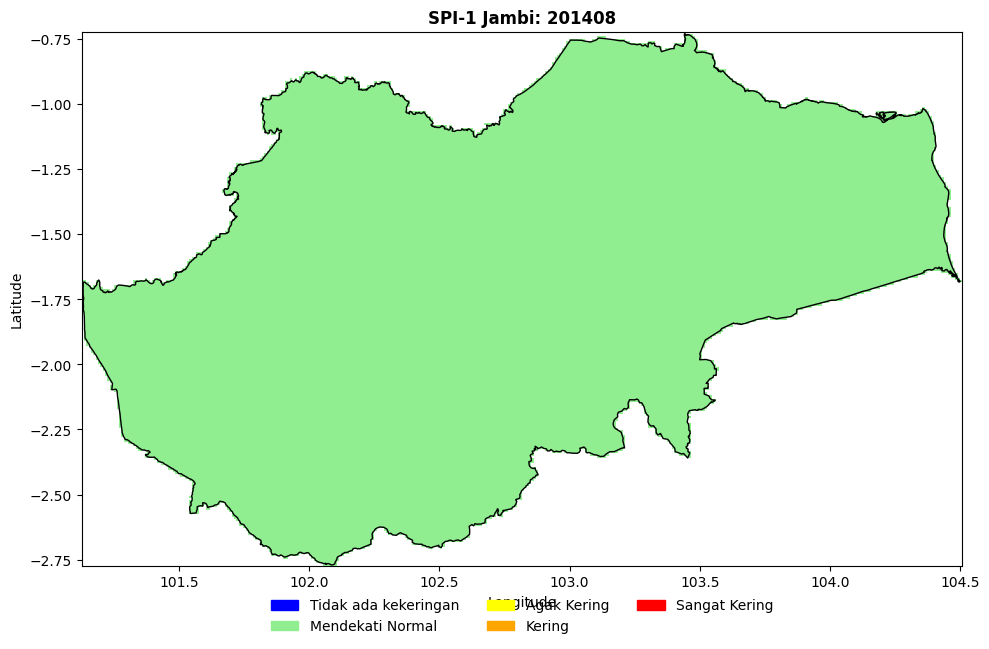

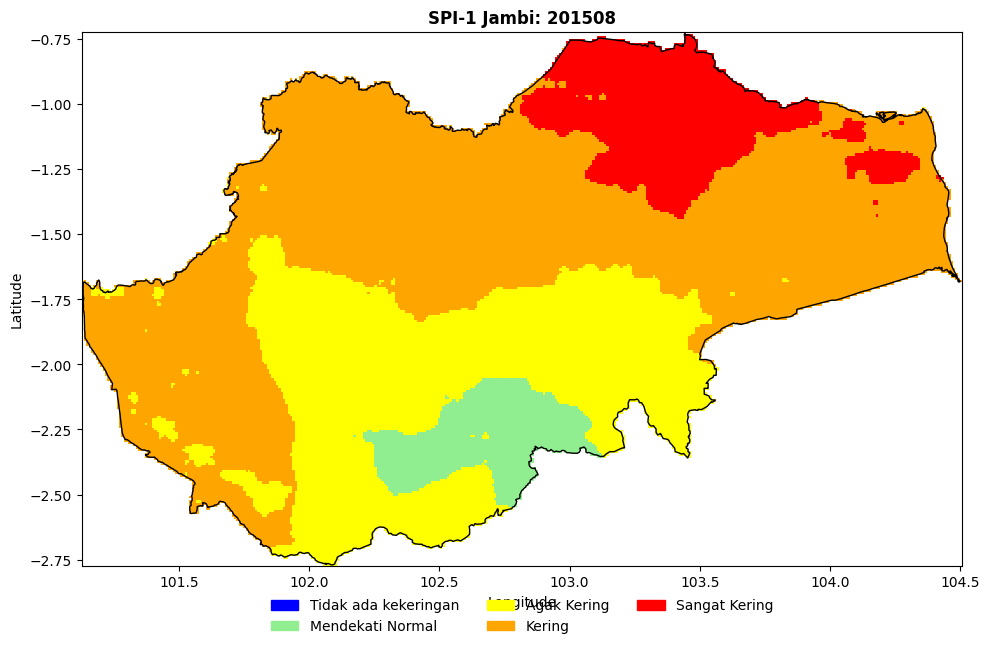

[SELESAI] Periode 2014-2015 tersimpan.

MEMPROSES: 2016-2017
>> Memulai proses loading data tahun 2016 s.d 2017...
>> Data berhasil digabungkan.
>> Menghitung SPI-1...
>> Menyimpan output...


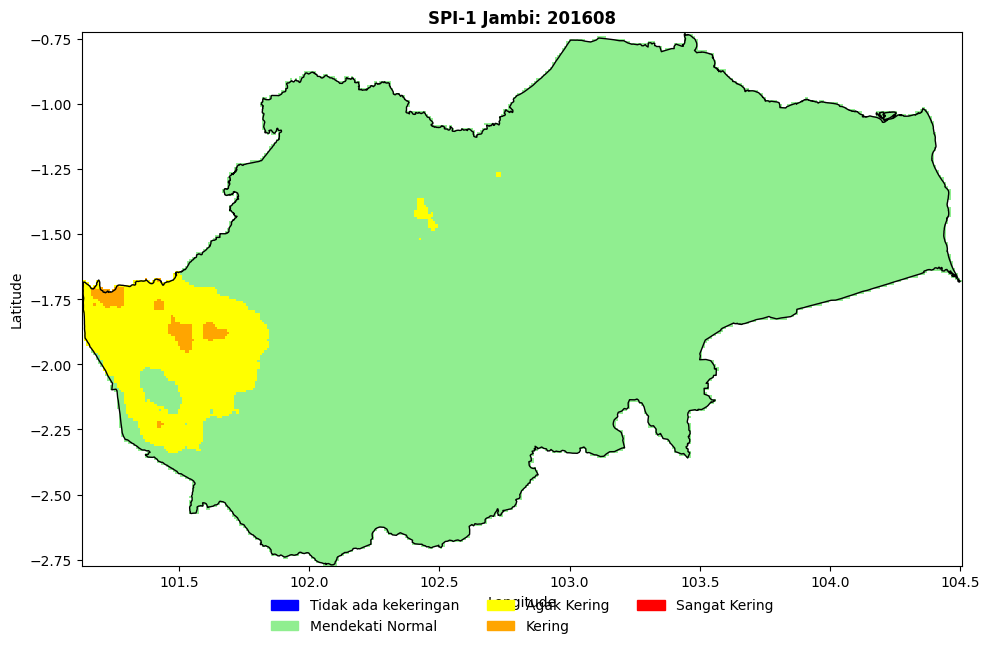

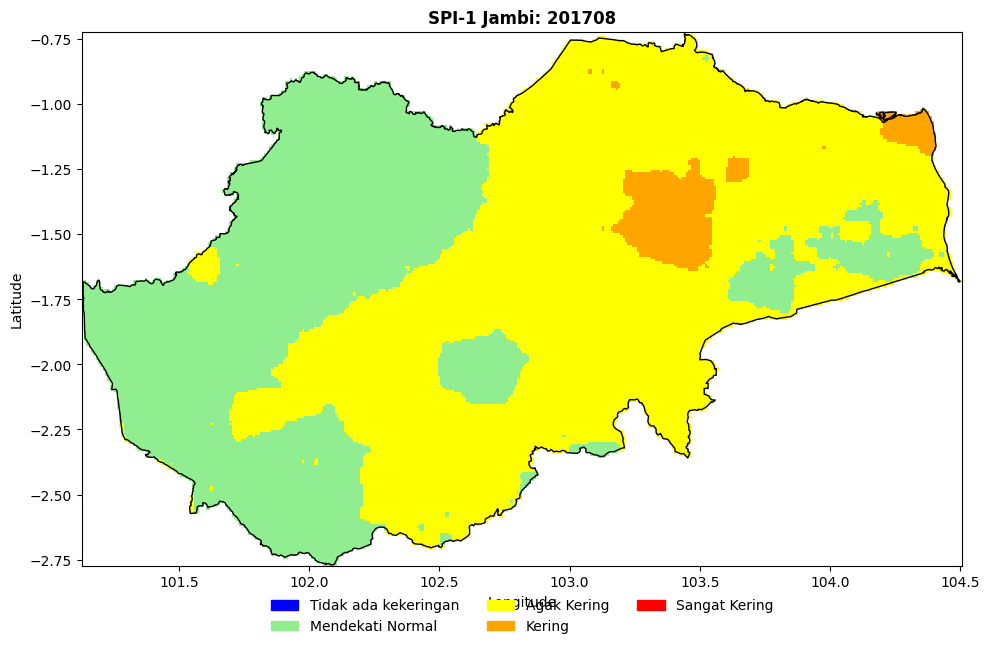

[SELESAI] Periode 2016-2017 tersimpan.

MEMPROSES: 2018-2020
>> Memulai proses loading data tahun 2018 s.d 2020...
>> Data berhasil digabungkan.
>> Menghitung SPI-1...
>> Menyimpan output...


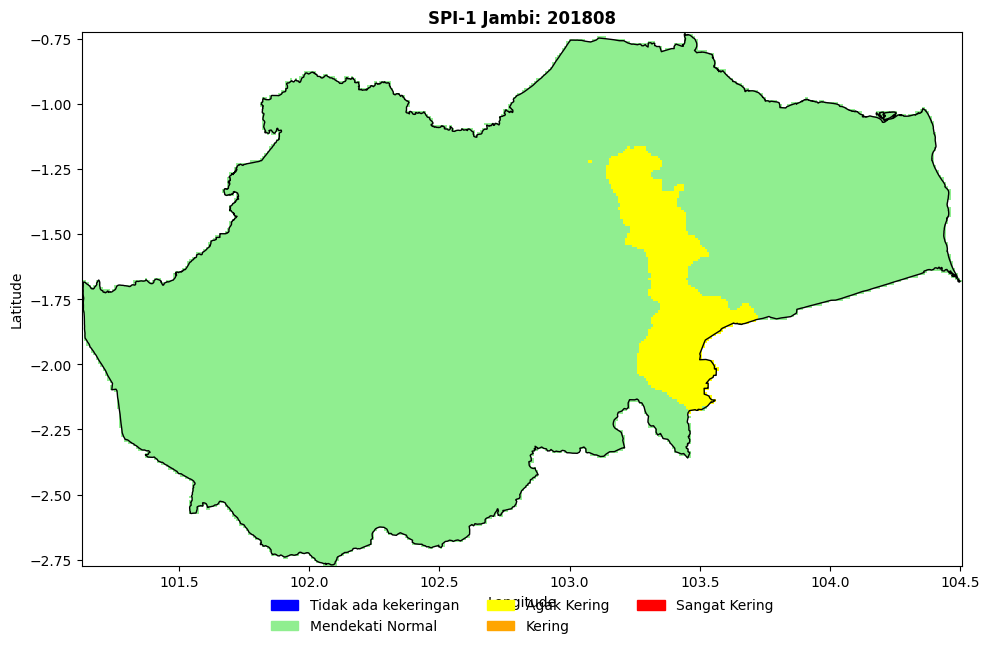

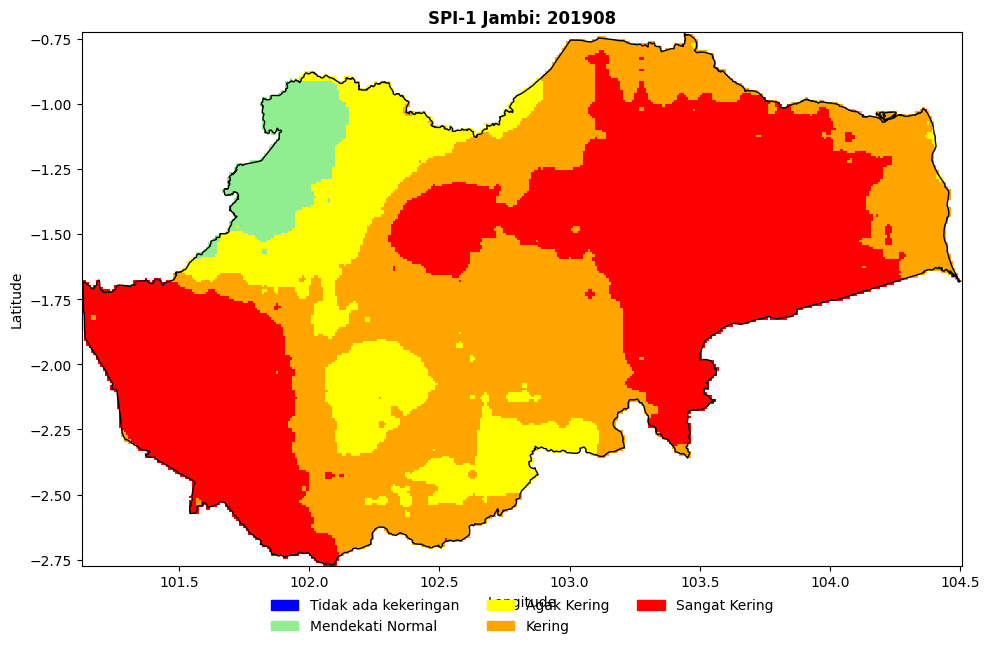

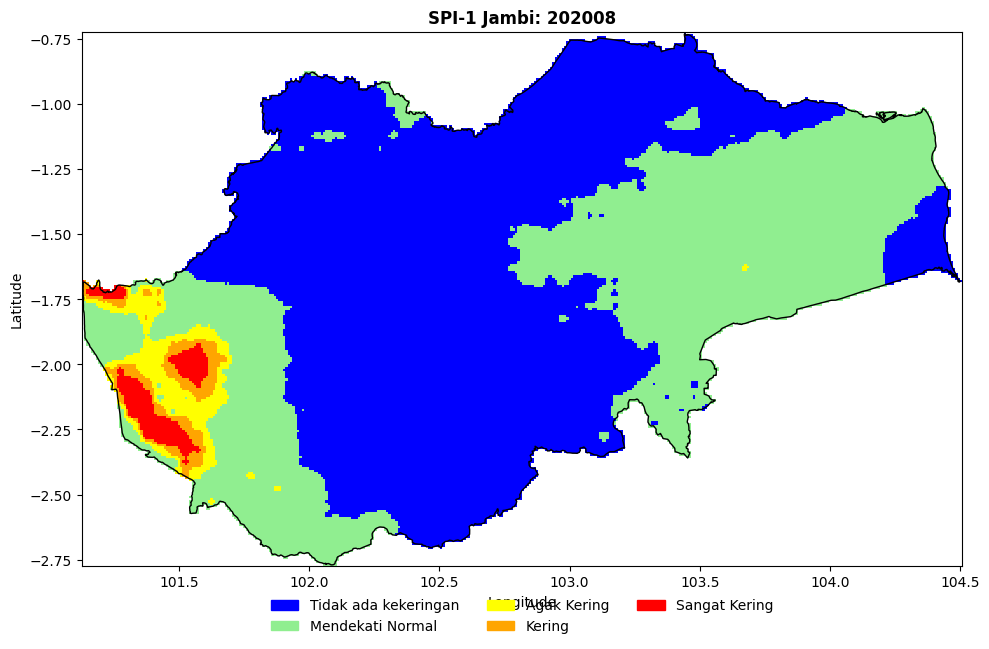

[SELESAI] Periode 2018-2020 tersimpan.


>>> SELURUH PROSES SELESAI <<<


In [ ]:
## 5. EKSEKUSI PROGRAM
# ------------------------------------------------------------------------------
if __name__ == '__main__':
    # Opsional: Cek apakah file 2009 sudah ada di folder input sebelum run
    print("Memulai pemrosesan data termasuk tahun 2009...")

    # GABUNGKAN 2009 ke periode pertama (misal jadi 3 tahun: 2009-2011)
    # Tujuannya agar distribusi data lebih panjang sedikit untuk perhitungan Gamma
    run_processing_period(2009, 2011)

    # Periode 2: 2012 - 2013
    run_processing_period(2012, 2013)

    # Periode 3: 2014 - 2015
    run_processing_period(2014, 2015)

    # Periode 4: 2016 - 2017
    run_processing_period(2016, 2017)

    # Periode 5: 2018 - 2020
    run_processing_period(2018, 2020)

    print("\n\n>>> SELURUH PROSES SELESAI <<<")